
# SUPPORT Notebook

This notebook runs through investigations on the open access SUPPORT dataset.

For users who do not have lots of computational resources or do not have access to MIMIC-III then this notebook should be used.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import torch
import math

# VAE is in other folder as well as opacus adapted library
import sys

sys.path.append("../")

# Opacus support for differential privacy
from opacus.utils.uniform_sampler import UniformWithReplacementSampler

# For VAE dataset formatting
from torch.utils.data import TensorDataset, DataLoader

# VAE functions
from VAE import Decoder, Encoder, VAE

# Utility file contains all functions required to run notebook
from utils import (
    set_seed,
    mimic_pre_proc,
    plot_elbo,
    plot_likelihood_breakdown,
    plot_variable_distributions,
    reverse_transformers,
)
from metrics import distribution_metrics, privacy_metrics

import warnings

warnings.filterwarnings("ignore")  # We suppress warnings to avoid SDMETRICS throwing unique synthetic data warnings (i.e.
# data in synthetic set is not in the real data set) as well as SKLEARN throwing convergence warnings (pre-processing uses
# GMM from sklearn and this throws non convergence warnings)


## Data Loading & Column Definitions

First we load in the SUPPORT dataset from pycox datasets. Then we define the continuous and categorical columns in that dataset

In [2]:
# bgpclear.csv data are all read as object dtype
df = pd.read_csv("data/bgpclear.csv")

In [3]:
df['Producer'].unique()

array(['leaf2', 'spine3', 'leaf8', 'leaf1', 'leaf6', 'spine1', 'leaf5',
       'spine4', 'leaf7', 'leaf3', 'spine2', 'dr01', 'dr03', 'dr02',
       'Producer'], dtype=object)

In [4]:
df['name'].unique()

array(['Cisco-IOS-XR-fib-common-oper:fib-statistics/nodes/node/drops',
       'name',
       'Cisco-IOS-XR-infra-statsd-oper:infra-statistics/interfaces/interface/latest/data-rate',
       'Cisco-IOS-XR-infra-statsd-oper:infra-statistics/interfaces/interface/latest/generic-counters',
       'Cisco-IOS-XR-ip-rib-ipv4-oper:rib/vrfs/vrf/afs/af/safs/saf/ip-rib-route-table-names/ip-rib-route-table-name/protocol/bgp/as/information',
       'Cisco-IOS-XR-ipv4-bgp-oper:bgp/instances/instance/instance-active/default-vrf/process-info',
       'Cisco-IOS-XR-nto-misc-oper:memory-summary/nodes/node/summary',
       'Cisco-IOS-XR-wdsysmon-fd-oper:system-monitoring/cpu-utilization'],
      dtype=object)

In [5]:
unique_producers = ["leaf1", "leaf2", "leaf3", "leaf5", "leaf6", "leaf7", "leaf8", "spine1", "spine2", "spine3", "spine4"]
features = [
            "active-routes-count",
            "as",
            "backup-routes-count",
            "deleted-routes-count",
            "paths-count",
            "protocol-route-memory",
            "routes-counts",
            "global__established-neighbors-count-total",
            "global__neighbors-count-total",
            "global__nexthop-count",
            "global__restart-count",
            "performance-statistics__global__configuration-items-processed",
            "performance-statistics__global__ipv4rib-server__rib-connection-up-count",
            "performance-statistics__vrf__inbound-update-messages",
            "vrf__neighbors-count",
            "vrf__network-count",
            "vrf__path-count",
            "vrf__update-messages-received"]

In [6]:
df_features = df[features]
df_features = df_features.apply(lambda x: pd.to_numeric(x, errors='coerce'))
df_features = df_features.astype('float')
# df_features = df_features.dropna()
df_features['active-routes-count'].dropna().tolist()

cleaned_df = pd.DataFrame()
for col in features:
    cleaned_df[col] = df_features[col].dropna().tolist()
input_df = cleaned_df
cleaned_df

,active-routes-count,as,backup-routes-count,deleted-routes-count,paths-count,protocol-route-memory,routes-counts,global__established-neighbors-count-total,global__neighbors-count-total,global__nexthop-count,global__restart-count,performance-statistics__global__configuration-items-processed,performance-statistics__global__ipv4rib-server__rib-connection-up-count,performance-statistics__vrf__inbound-update-messages,vrf__neighbors-count,vrf__network-count,vrf__path-count,vrf__update-messages-received
0,162.0,65022.0,1.0,0.0,925.0,124464.0,163.0,37.0,39.0,151.0,2.0,2.0,1.0,67221.0,39.0,352.0,5857.0,67221.0
1,152.0,65013.0,0.0,0.0,1152.0,148480.0,152.0,56.0,64.0,231.0,2.0,14.0,1.0,63498.0,64.0,352.0,8353.0,63498.0
2,164.0,65028.0,0.0,0.0,957.0,128176.0,164.0,39.0,40.0,147.0,2.0,3.0,1.0,67186.0,40.0,352.0,5937.0,67186.0
3,165.0,65021.0,1.0,0.0,982.0,131232.0,166.0,38.0,38.0,140.0,2.0,5.0,1.0,69236.0,38.0,352.0,4769.0,69236.0
4,164.0,65026.0,0.0,0.0,980.0,130752.0,164.0,38.0,38.0,145.0,2.0,2.0,1.0,68497.0,38.0,352.0,6213.0,68497.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8628,165.0,65021.0,1.0,0.0,982.0,131232.0,166.0,38.0,38.0,140.0,2.0,6.0,1.0,72822.0,38.0,352.0,4687.0,72822.0
8629,165.0,65025.0,0.0,0.0,980.0,130880.0,165.0,37.0,37.0,139.0,2.0,2.0,1.0,69748.0,37.0,352.0,5297.0,69748.0
8630,164.0,65027.0,0.0,0.0,967.0,129296.0,164.0,38.0,38.0,145.0,2.0,2.0,1.0,71863.0,38.0,352.0,6213.0,71863.0
8631,167.0,65501.0,1.0,0.0,772.0,107968.0,168.0,28.0,32.0,119.0,2.0,7.0,1.0,113835.0,32.0,352.0,1975.0,113835.0


In [7]:
# Find one sub datset that name==data-rate, Producer==leaf4
# tmp_df = df[(df['name']=='Cisco-IOS-XR-infra-statsd-oper:infra-statistics/interfaces/interface/latest/data-rate') & (df['Producer']=='leaf1')]

# input_df = tmp_df.dropna(axis=1, how='all')
# # input_df = tmp_df.select_dtypes(exclude=['object'])
# # tmp_df = tmp_df.drop(['time'], axis=1)
# input_df = input_df.drop(['time', 'name', 'EncodingPath', 'Producer', 'interface-name', 'bandwidth'], axis=1)
# input_df = input_df.astype('float')
# input_df = input_df.astype('int64')
# input_df

In [8]:
categorical_column_name=[]
categorical_len_count=0
for col in input_df:
    if len(input_df[col].unique()) <= 100:
        categorical_column_name.append(col)
        categorical_len_count += len(input_df[col].unique())

In [9]:
len(categorical_column_name)

13

In [10]:
# Column Definitions
original_continuous_columns = list(set(input_df.columns.values.tolist()) - set(categorical_column_name))
original_categorical_columns = categorical_column_name
# original_continuous_columns = ['output-packet-rate']
# original_categorical_columns = ['load-interval']
# tmp_df = tmp_df[['load-interval', 'output-packet-rate']]


In [25]:
df_continuous_columns = list(original_continuous_columns)
continuous_df = input_df[df_continuous_columns]

df_categorical_columns = list(original_categorical_columns)
discrete_df = input_df[df_categorical_columns]

continuous_data = continuous_df.to_numpy()
discrete_data = discrete_df.to_numpy()

# Define the original data tensor
continuous_data = torch.tensor(continuous_data)
discrete_data = torch.tensor(discrete_data)

# Define the privacy budget
privacy_budget = 1e-4

# Define the noise scale (standard deviation of the Gaussian noise)
noise_scale = 5.0

# Add the Gaussian noise to the continuous data
continuous_noisy_data = continuous_data + torch.tensor(np.random.randint(-noise_scale, noise_scale, size=continuous_data.shape))

# # Add the int noise to the discrete data
discrete_noisy_data = discrete_data + torch.tensor(np.random.randint(-noise_scale, noise_scale, size=discrete_data.shape))
# Set the negative values into 0
discrete_noisy_data[discrete_noisy_data < 0] = 0

# Calculate the sensitivity of the function (maximum difference between two adjacent datasets)
sensitivity = torch.max(torch.abs(continuous_data - (continuous_data + torch.ones_like(continuous_data))) )

# Calculate delta (probability of the function output deviating from the true output by more than epsilon)
delta = 1 / len(continuous_data)

# Calculate the epsilon value
epsilon = privacy_budget / delta

# Check if the privacy guarantee is satisfied
if epsilon <= sensitivity / noise_scale:
    print("The function satisfies differential privacy with epsilon = ", epsilon)
else:
    print("The function does not satisfy differential privacy with epsilon = ", epsilon)


The function does not satisfy differential privacy with epsilon =  0.8633000000000001


In [26]:
continuous_df

,protocol-route-memory,performance-statistics__vrf__inbound-update-messages,vrf__path-count,vrf__update-messages-received,paths-count
0,124464.0,67221.0,5857.0,67221.0,925.0
1,148480.0,63498.0,8353.0,63498.0,1152.0
2,128176.0,67186.0,5937.0,67186.0,957.0
3,131232.0,69236.0,4769.0,69236.0,982.0
4,130752.0,68497.0,6213.0,68497.0,980.0
...,...,...,...,...,...
8628,131232.0,72822.0,4687.0,72822.0,982.0
8629,130880.0,69748.0,5297.0,69748.0,980.0
8630,129296.0,71863.0,6213.0,71863.0,967.0
8631,107968.0,113835.0,1975.0,113835.0,772.0


In [27]:
discrete_noisy_df = pd.DataFrame(discrete_noisy_data, columns=df_categorical_columns)
continuous_noisy_df = pd.DataFrame(continuous_noisy_data, columns=df_continuous_columns)

continuous_noisy_df

,protocol-route-memory,performance-statistics__vrf__inbound-update-messages,vrf__path-count,vrf__update-messages-received,paths-count
0,124461.0,67225.0,5855.0,67221.0,922.0
1,148483.0,63501.0,8353.0,63496.0,1147.0
2,128173.0,67187.0,5935.0,67189.0,961.0
3,131232.0,69235.0,4772.0,69240.0,979.0
4,130754.0,68493.0,6214.0,68500.0,984.0
...,...,...,...,...,...
8628,131234.0,72820.0,4682.0,72821.0,981.0
8629,130877.0,69745.0,5296.0,69743.0,981.0
8630,129297.0,71859.0,6214.0,71866.0,964.0
8631,107970.0,113833.0,1978.0,113837.0,768.0


In [28]:
noisy_tmp_df = pd.concat([discrete_noisy_df, continuous_noisy_df], axis=1)
noisy_tmp_df

,active-routes-count,as,backup-routes-count,deleted-routes-count,routes-counts,global__established-neighbors-count-total,global__neighbors-count-total,global__nexthop-count,global__restart-count,performance-statistics__global__configuration-items-processed,performance-statistics__global__ipv4rib-server__rib-connection-up-count,vrf__neighbors-count,vrf__network-count,protocol-route-memory,performance-statistics__vrf__inbound-update-messages,vrf__path-count,vrf__update-messages-received,paths-count
0,162.0,65018.0,0.0,4.0,164.0,39.0,40.0,150.0,1.0,6.0,0.0,43.0,350.0,124461.0,67225.0,5855.0,67221.0,922.0
1,154.0,65010.0,0.0,0.0,152.0,52.0,66.0,232.0,0.0,17.0,5.0,68.0,352.0,148483.0,63501.0,8353.0,63496.0,1147.0
2,167.0,65029.0,0.0,0.0,162.0,34.0,44.0,151.0,4.0,6.0,5.0,38.0,356.0,128173.0,67187.0,5935.0,67189.0,961.0
3,165.0,65019.0,0.0,3.0,169.0,34.0,37.0,143.0,3.0,7.0,0.0,40.0,354.0,131232.0,69235.0,4772.0,69240.0,979.0
4,161.0,65025.0,0.0,2.0,164.0,37.0,35.0,144.0,0.0,0.0,5.0,35.0,356.0,130754.0,68493.0,6214.0,68500.0,984.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8628,166.0,65017.0,0.0,2.0,168.0,40.0,39.0,144.0,0.0,5.0,4.0,38.0,347.0,131234.0,72820.0,4682.0,72821.0,981.0
8629,163.0,65022.0,0.0,0.0,163.0,34.0,39.0,141.0,3.0,0.0,3.0,32.0,353.0,130877.0,69745.0,5296.0,69743.0,981.0
8630,168.0,65023.0,0.0,0.0,166.0,41.0,41.0,146.0,0.0,0.0,0.0,42.0,350.0,129297.0,71859.0,6214.0,71866.0,964.0
8631,171.0,65501.0,3.0,0.0,163.0,24.0,32.0,117.0,3.0,6.0,0.0,32.0,349.0,107970.0,113833.0,1978.0,113837.0,768.0


## Data Pre-Processing

Data can be pre-processed in 2 ways. Either we use <b>"standard"</b> option which performs a standard scaler on continuous variables - This has known limitations as:

- Data in tables is usually non-gaussian and SynthVAE implements a gaussian loss, so this will perform worse unless the data is KNOWN to follow a gaussian distribution already.

Or we use the second option of <b>"GMM"</b>. This performs a variational gaussian mixture model to scale the data & transform it to a gaussian distribution. We use a maximum number of clusters of 10 but the variational method will select the best number of clusters for that continuous variable. This also has known limitations:

- 10 Clusters is arbitrary and may not be enough for certain variables.
- We are fitting a model to transform the data and hence we are approximating before model is trained. This will lose fidelity as the distribution will not be transformed perfectly.

SUPPORT is a limited dataset as it has no missingness (which our model currently does NOT handle) and it has no datetime columns or other data types. Be wary drawing any conclusions from this set due to these constraints as well as the dataset size. Testing/training new models with this set could be useful but conclusive results should be tested on other sets.

In [29]:

pre_proc_method = "GMM"

# (
#     x_train,
#     tmp_df,
#     reordered_dataframe_columns,
#     continuous_transformers,
#     categorical_transformers,
#     num_categories,
#     num_continuous,
# ) = support_pre_proc(data_supp=tmp_df, 
#                      continuous_columns=original_continuous_columns,
#                      categorical_columns=original_categorical_columns,
#                      all_possible_categories=categorical_len_count,
#                      pre_proc_method=pre_proc_method)

(
    x_train,
    tmp_df,
    reordered_dataframe_columns,
    continuous_transformers,
    categorical_transformers,
    num_categories,
    num_continuous,
) = mimic_pre_proc(noisy_tmp_df,
                   original_continuous_columns,
                   original_categorical_columns,
                   pre_proc_method=pre_proc_method)



0 active-routes-count ------index, column
1 as ------index, column
2 backup-routes-count ------index, column
3 deleted-routes-count ------index, column
4 routes-counts ------index, column
5 global__established-neighbors-count-total ------index, column
6 global__neighbors-count-total ------index, column
7 global__nexthop-count ------index, column
8 global__restart-count ------index, column
9 performance-statistics__global__configuration-items-processed ------index, column
10 performance-statistics__global__ipv4rib-server__rib-connection-up-count ------index, column
11 vrf__neighbors-count ------index, column
12 vrf__network-count ------index, column
13 protocol-route-memory.component ------index, column
14 performance-statistics__vrf__inbound-update-messages.component ------index, column
15 vrf__path-count.component ------index, column
16 vrf__update-messages-received.component ------index, column
17 paths-count.component ------index, column


In [30]:
x_train.shape

(8633, 461)

In [31]:
num_continuous

5

In [32]:
num_categories

[40, 39, 6, 30, 41, 61, 34, 52, 7, 21, 6, 34, 44, 8, 6, 10, 7, 10]

## Creation & Training of VAE

We can adapt certain parameters of the model e.g. batch size, latent dimension size etc. This model implements early stopping and these values can be adapted.

We can also activate differential privacy by implementing dp-sgd through the opacus library.

In [71]:
# User defined hyperparams
# General training
batch_size = 100
latent_dim = 512
hidden_dim = 1024
n_epochs = 10
logging_freq = 1  # Number of epochs we should log the results to the user
patience = 50  # How many epochs should we allow the model train to see if
# improvement is made
delta = 10  # The difference between elbo values that registers an improvement
filepath = None  # Where to save the best model


# Privacy params
differential_privacy = False  # Do we want to implement differential privacy
sample_rate = 0.1  # Sampling rate
C = 1e16  # Clipping threshold any gradients above this are clipped
noise_scale = 0.2  # Noise multiplier - influences how much noise to add
target_eps = 10  # Target epsilon for privacy accountant
target_delta = 1e-5  # Target delta for privacy accountant

# Prepare data for interaction with torch VAE
Y = torch.Tensor(x_train)
dataset = TensorDataset(Y)

generator = None
sample_rate = batch_size / len(dataset)
data_loader = DataLoader(
    dataset,
    batch_sampler=UniformWithReplacementSampler(
        num_samples=len(dataset), sample_rate=sample_rate, generator=generator
    ),
    pin_memory=True,
    generator=generator,
)

# Create VAE
encoder = Encoder(x_train.shape[1], latent_dim, hidden_dim=hidden_dim)
decoder = Decoder(latent_dim, num_continuous, hidden_dim=hidden_dim, num_categories=num_categories)

vae = VAE(encoder, decoder)

print(vae)

if differential_privacy == False:
    (
        training_epochs,
        log_elbo,
        log_reconstruction,
        log_divergence,
        log_categorical,
        log_numerical,
    ) = vae.train(
        data_loader, 
        n_epochs=n_epochs,
        logging_freq=logging_freq,
        patience=patience,
        delta=delta,
    )

elif differential_privacy == True:
    (
        training_epochs,
        log_elbo,
        log_reconstruction,
        log_divergence,
        log_categorical,
        log_numerical,
    ) = vae.diff_priv_train(
        data_loader,
        n_epochs=n_epochs,
        logging_freq=logging_freq,
        patience=patience,
        delta=delta,
        C=C,
        target_eps=target_eps,
        target_delta=target_delta,
        sample_rate=sample_rate,
        noise_scale=noise_scale,
    )
    print(f"(epsilon, delta): {vae.get_privacy_spent(target_delta)}")

# save the model
PATH = "vae_model.pt"
torch.save(vae.state_dict(), PATH)

Encoder: gpu specified, cpu used
Decoder: gpu specified, cpu used
VAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=461, out_features=1024, bias=True)
      (1): Tanh()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1024, out_features=1024, bias=True)
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): Tanh()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1024, out_features=461, bias=True)
    )
  )
  (noiser): Noiser(
    (output_logsigma_fn): Linear(in_features=5, out_features=5, bias=True)
  )
)


100%|██████████| 86/86 [00:01<00:00, 44.06it/s]


	Epoch:  0. Elbo:    43910.32. Reconstruction Loss:    42913.98. KL Divergence:      996.34. Categorical Loss:    -4035.24. Numerical Loss:   -38878.75


100%|██████████| 86/86 [00:01<00:00, 45.46it/s]


	Epoch:  1. Elbo:    39537.49. Reconstruction Loss:    39510.79. KL Divergence:       26.70. Categorical Loss:    -3801.76. Numerical Loss:   -35709.03


100%|██████████| 86/86 [00:01<00:00, 45.39it/s]


	Epoch:  2. Elbo:    35677.24. Reconstruction Loss:    35658.52. KL Divergence:       18.72. Categorical Loss:    -3809.30. Numerical Loss:   -31849.22


100%|██████████| 86/86 [00:01<00:00, 45.51it/s]


	Epoch:  3. Elbo:    32512.01. Reconstruction Loss:    32487.35. KL Divergence:       24.66. Categorical Loss:    -3810.66. Numerical Loss:   -28676.69


100%|██████████| 86/86 [00:01<00:00, 45.52it/s]


	Epoch:  4. Elbo:    29236.28. Reconstruction Loss:    29195.21. KL Divergence:       41.07. Categorical Loss:    -3819.87. Numerical Loss:   -25375.34


100%|██████████| 86/86 [00:01<00:00, 45.57it/s]


	Epoch:  5. Elbo:    26371.80. Reconstruction Loss:    26300.48. KL Divergence:       71.32. Categorical Loss:    -3835.06. Numerical Loss:   -22465.42


100%|██████████| 86/86 [00:01<00:00, 45.61it/s]


	Epoch:  6. Elbo:    23082.57. Reconstruction Loss:    23002.81. KL Divergence:       79.76. Categorical Loss:    -3821.46. Numerical Loss:   -19181.35


100%|██████████| 86/86 [00:01<00:00, 45.66it/s]


	Epoch:  7. Elbo:    20351.56. Reconstruction Loss:    20215.70. KL Divergence:      135.86. Categorical Loss:    -3827.09. Numerical Loss:   -16388.61


100%|██████████| 86/86 [00:02<00:00, 42.99it/s]


	Epoch:  8. Elbo:    17914.41. Reconstruction Loss:    17727.73. KL Divergence:      186.68. Categorical Loss:    -3843.86. Numerical Loss:   -13883.87


100%|██████████| 86/86 [00:02<00:00, 41.88it/s]

	Epoch:  9. Elbo:    15552.44. Reconstruction Loss:    15293.10. KL Divergence:      259.34. Categorical Loss:    -3859.56. Numerical Loss:   -11433.54


## Plotting Elbo Functionality

Here we can plot and save the ELBO graph for the training run

In [ ]:

elbo_fig = plot_elbo(
    n_epochs=training_epochs,
    log_elbo=log_elbo,
    log_reconstruction=log_reconstruction,
    log_divergence=log_divergence,
    saving_filepath="",
)


## Plotting Reconstruction Breakdown

Here we can plot the breakdown of reconstruction loss i.e. visualise how the categorical and numerical losses change over training

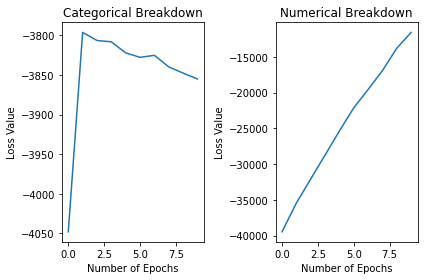

In [35]:

likelihood_fig = plot_likelihood_breakdown(
    n_epochs=training_epochs,
    log_categorical=log_categorical,
    log_numerical=log_numerical,
    saving_filepath="",
    pre_proc_method=pre_proc_method,
)


## Synthetic Data Generation

Here we create synthetic data ready for metric testing as well as visualisation of variable reconstruction. For this we simply generate from our generative model and then reverse transformations using the prior transformers.

In [34]:
synthetic_sample = vae.generate(x_train.shape[0])

if torch.cuda.is_available():
    synthetic_sample = pd.DataFrame(
        synthetic_sample.cpu().detach().numpy(), 
        columns=reordered_dataframe_columns
    )
else:
    synthetic_sample = pd.DataFrame(
        synthetic_sample.detach().numpy(), 
        columns=reordered_dataframe_columns
    )
# Reverse the transformations

synthetic_supp = reverse_transformers(
    synthetic_set=synthetic_sample,
    data_supp_columns=tmp_df.columns,
    cont_transformers=continuous_transformers,
    cat_transformers=categorical_transformers,
    pre_proc_method=pre_proc_method,
)


## Synthetic Variable Visualisation

Here we want to visualise the synthetic variables generated and compare them to the original set

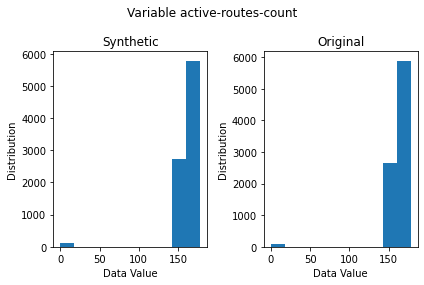

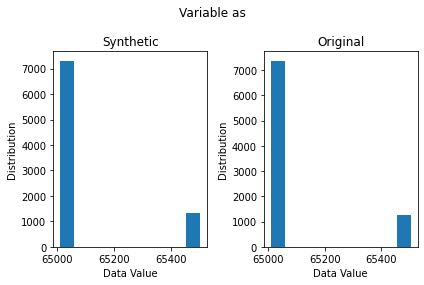

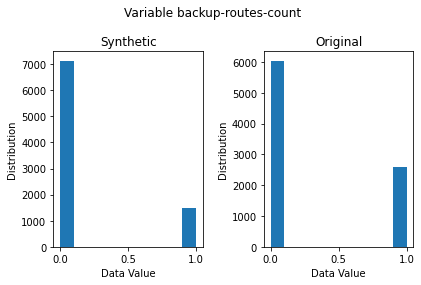

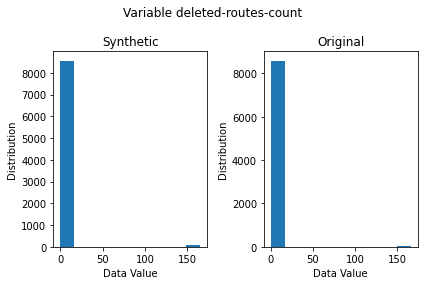

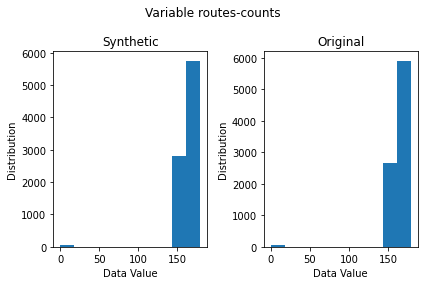

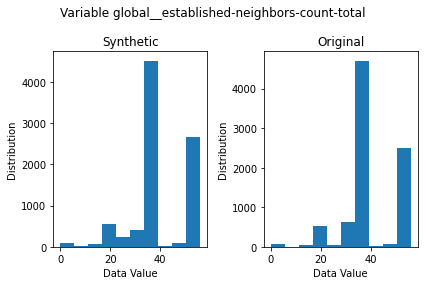

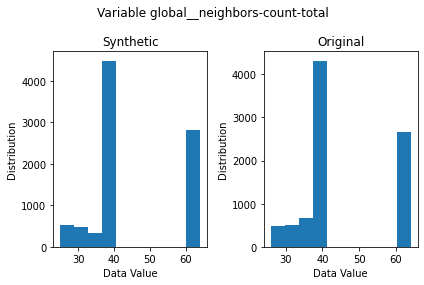

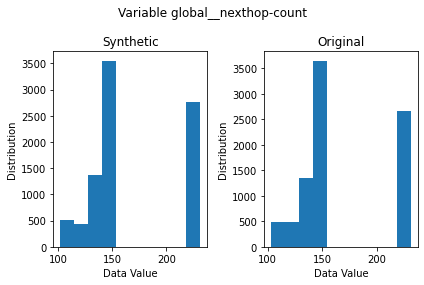

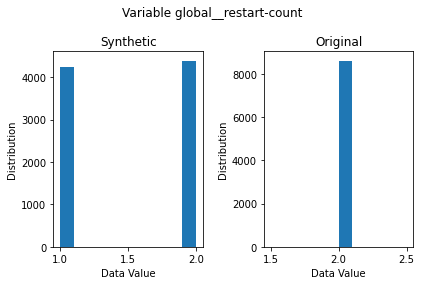

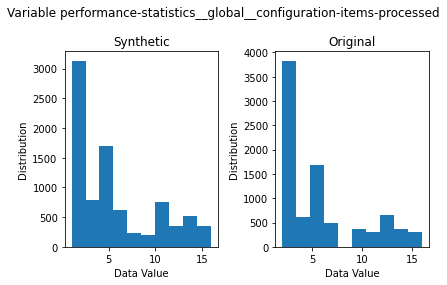

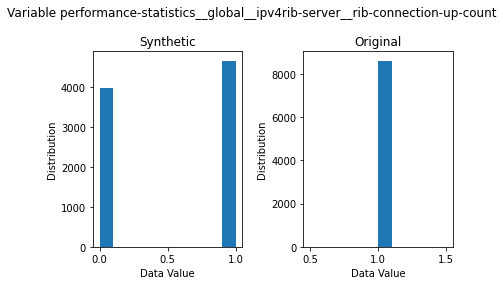

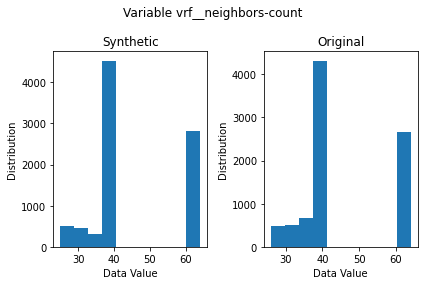

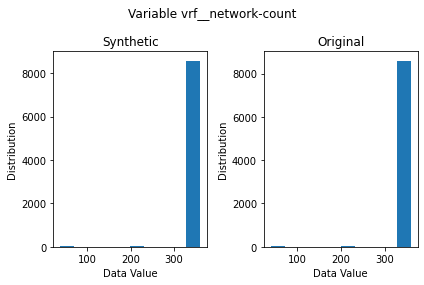

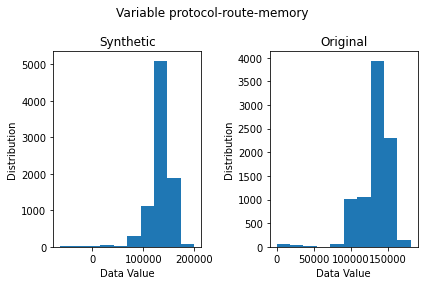

In [25]:

plot_variable_distributions(
    categorical_columns=original_categorical_columns,
    continuous_columns=original_continuous_columns,
    data_supp=input_df,
    synthetic_supp=synthetic_supp,
    saving_filepath="figs/",
    pre_proc_method=pre_proc_method,
)


## Metric evaluation

We use the SDV evaluation framework. Supply the metrics you wish to find in the distributional_metrics list from SDV guidance. Can start here: https://sdv.dev/SDV/user_guides/evaluation/single_table_metrics.html

Note that not all of these will work, some are hit and miss. We predominantly rely on continuous and discrete KL divergence measures. You can also input <b>"gower"</b> and this will calculate the gower distance using the gower library.

In [48]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
pd.set_option("display.precision", 3)

def cal_err_rate(synthetic_data, real_data):
    err_rate = (synthetic_data - real_data)/real_data
    return err_rate

## Query metric 1: mean

<function matplotlib.pyplot.show(close=None, block=None)>

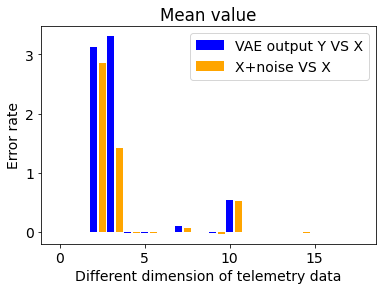

In [57]:
vae_generation_mean = cal_err_rate(synthetic_supp.mean(), input_df.mean())
noise_mean = cal_err_rate(noisy_tmp_df.mean(), input_df.mean())

x = [i for i in range(18)]
x1 = [i+0.5 for i in range(18)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x, vae_generation_mean, width=0.4, color='blue', label='VAE output Y VS X')
ax.bar(x1, noise_mean, width=0.4, color='orange', label='X+noise VS X')

plt.legend()
plt.ylabel('Error rate')
# plt.ylim(0, 4)
plt.xlabel( 'Different dimension of telemetry data' )
plt.title('Mean value')
plt.show

## Query metric 2: quantile

<function matplotlib.pyplot.show(close=None, block=None)>

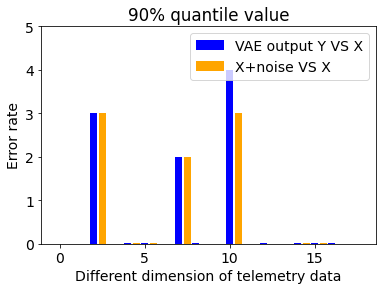

In [59]:
vae_generation_mean = cal_err_rate(synthetic_supp.quantile(0.9), input_df.quantile(0.9))
noise_mean = cal_err_rate(noisy_tmp_df.quantile(0.9), input_df.quantile(0.9))

x = [i for i in range(18)]
x1 = [i+0.5 for i in range(18)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x, vae_generation_mean, width=0.4, color='blue', label='VAE output Y VS X')
ax.bar(x1, noise_mean, width=0.4, color='orange', label='X+noise VS X')

plt.legend()
plt.ylabel('Error rate')
plt.ylim(0, 5)
plt.xlabel( 'Different dimension of telemetry data' )
plt.title('90% quantile value')
plt.show

## Distribution metric: KSTest

In [62]:
# Define distributional metrics required - for sdv_baselines this is set by default
# distributional_metrics = [
#     "SVCDetection",
#     "GMLogLikelihood",
#     "CSTest",
#     "KSTest",
#     "KSTestExtended",
#     "ContinuousKLDivergence",
#     "DiscreteKLDivergence",
# ]

distributional_metrics = [
    "KSTest",
#     "ContinuousKLDivergence",
#     "DiscreteKLDivergence",
]

gower = False

vae_metrics = distribution_metrics(
    distributional_metrics=distributional_metrics,
    data_supp=input_df,
    synthetic_supp=synthetic_supp,
    categorical_columns=original_categorical_columns
)

manual_noise_metrics = distribution_metrics(
    distributional_metrics=distributional_metrics,
    data_supp=input_df,
    synthetic_supp=noisy_tmp_df,
    categorical_columns=original_categorical_columns
)

<function matplotlib.pyplot.show(close=None, block=None)>

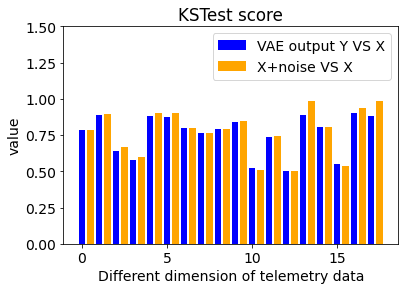

In [63]:
vae_ks_score=vae_metrics['KSTest_score'].to_list()
manual_ks_score=manual_noise_metrics['KSTest_score'].to_list()

x = [i for i in range(18)]
x1 = [i+0.5 for i in range(18)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x, vae_ks_score, width=0.4, color='blue', label='VAE output Y VS X')
ax.bar(x1, manual_ks_score, width=0.4, color='orange', label='X+noise VS X')

plt.legend()
plt.ylabel('value')
plt.ylim(0, 1.5)
plt.xlabel( 'Different dimension of telemetry data' )
plt.title('KSTest score')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

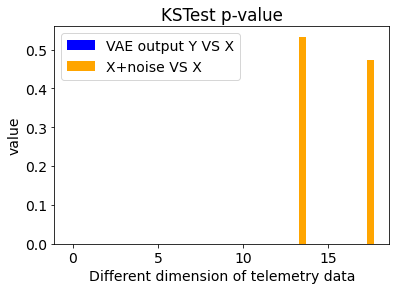

In [68]:
vae_ks_pvalue=vae_metrics['KSTest_p_value'].to_list()
manual_ks_pvalue=manual_noise_metrics['KSTest_p_value'].to_list()

x = [i for i in range(18)]
x1 = [i+0.5 for i in range(18)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x, vae_ks_pvalue, width=0.4, color='blue', label='VAE output Y VS X')
ax.bar(x1, manual_ks_pvalue, width=0.4, color='orange', label='X+noise VS X')

plt.legend()
plt.ylabel('value')
# plt.ylim(0, 1e-30)
plt.xlabel( 'Different dimension of telemetry data' )
plt.title('KSTest p-value')
plt.show

# Privacy Metric Evaluation

Using SDV privacy metrics we can get an insight into how privacy is conserved when utilising dp-sgd methods. SDV's privacy metrics are limited in that they can only be used on similar data types. E.g. if we choose age to be the sensitive variably, we can build ML based models to predict a users age using the other columns. However we are forced to only use columns that are also continuous variables.

In [ ]:
# Specify our private variable

private_variable = "input-data-rate"

privacy_metric = privacy_metrics(
    private_variable=private_variable,
    data_supp=tmp_df,
    synthetic_supp=synthetic_supp,
    categorical_columns=original_categorical_columns,
    continuous_columns=original_continuous_columns,
    saving_filepath=None,
    pre_proc_method=pre_proc_method,
)



In [ ]:
privacy_metric